***In this assignment, a summarization task will be performed in Turkish with transformers (T5ForConditionalGeneration) using 2 different Turkish data sets. The first data set is "mlsum", and the second is 270k interpress_news_category_tr data set.***

This notebook is written on Colab Pro

Check our GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  5 16:20:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check high-RAM capability

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


pip install packages

In [4]:
!pip install transformers -q
!pip install wandb -q
!pip install sentencepiece
!pip install folium==0.2.1
!pip install datasets

     |████████████████████████████████| 4.2 MB 7.5 MB/s 
     |████████████████████████████████| 6.6 MB 78.6 MB/s 
     |████████████████████████████████| 596 kB 85.6 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 1.8 MB 8.9 MB/s 
     |████████████████████████████████| 145 kB 87.2 MB/s 
     |████████████████████████████████| 181 kB 82.6 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 9.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.7 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=d118fc497c0df9fcebb818289cf5c3e5ecd63d5a7a453ab5e98fbaed18cd4e36
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad6

import libraries

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import wandb
import torch
import torchvision
import numpy as np
# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
import tensorflow as tf
import os
from transformers import Trainer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
import shutil
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from datasets import load_dataset
import csv
# WandB – Import the wandb library
import wandb

In [6]:
# This is the google colab version 
!nvidia-smi

Sun Jun  5 16:21:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [8]:
# Login to wandb to log the model run and all the parameters
!wandb login 
## api key: 036d29e923bb61de5f855c63ad17c0fdaaf4b78f

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
# CustomDataset for finetuning model to use our external dataset

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.summary = self.data.summary

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        summary = str(self.summary[index])
        summary = ' '.join(summary.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([summary], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [10]:
# Training function
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
# validation
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [12]:
df = load_dataset('mlsum', 'tu')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/249277 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11565 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12775 [00:00<?, ? examples/s]

Dataset mlsum downloaded and prepared to /root/.cache/huggingface/datasets/mlsum/tu/1.0.0/77f23eb185781f439927ac2569ab1da1083195d8b2dab2b2f6bbe52feb600688. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
len(df['train'])

249277

In [14]:
df['train']['text'][0:25000]

['Araç sahipleri için pahalı benzine karşı yapılacak çözüm; tasarruf. Shell, Total, BP gibi sektörün önde gelen şirketlerinin araç sahiplerine yaptığı tavsiyelere göre 80 kilometre (km) hızla seyreden bir araç, 100 km hızla giden araca göre yüzde 30 daha az yakıt tüketiyor. Seyir halinde iken gereksiz klima çalıştırmamak, ani gaz-frene basmaktan kaçınmak, aracın camlarını kapalı tutmak tasarruf sağlıyor. Daha az yakıt tüketimi, ilk olarak araç bakımlarının düzenli yapılmasıyla başlıyor. Bunun için motor ve lastik bakımları öne çıkıyor. Kirli bujilerin değiştirilmesi yüzde 5 tasarruf sağlıyor. Lastik havalarının kontrolü, verimi yüzde 3 artırıyor. Gereksiz bagajın maliyeti yüzde 5 daha fazla yakıt tüketmek. En önemli yakıt tasarrufu ise aracın hızıyla sağlanıyor. İngiliz Ulaştırma Bakanlığı çalışmasına göre saatte 100 km hızla giden bir araç, 80 km hızla giden araca göre yüzde 30 daha fazla yakıt harcıyor. Klimanın çalıştırılması, yakıt tüketimini yüzde 8 artırıyor. Uygun motor yağı kul

In [16]:
text = df['train']['text'][0:25000] ##text = df['train']['text']
summary = df['train']['summary'][0:25000] ##summary = df['train']['summary']
dt = pd.DataFrame(text)
ds = pd.DataFrame(summary)
text_array = np.array(dt)
summary_array = np.array(ds)
column_text = ['text']
column_summary = ['summary']
df_text = pd.DataFrame(data = text_array,columns = column_text)
df_summary = pd.DataFrame(data = summary_array,columns = column_summary)
frames = [df_text, df_summary]
results = pd.concat(frames, axis=1)
results

,text,summary
0,"Araç sahipleri için pahalı benzine karşı yapılacak çözüm; tasarruf. Shell, Total, BP gibi sektörün önde gelen şirketlerinin araç sahiplerine yaptığı tavsiyelere göre 80 kilometre (km) hızla seyreden bir araç, 100 km hızla giden araca göre yüzde 30 daha az yakıt tüketiyor. Seyir halinde iken gereksiz klima çalıştırmamak, ani gaz-frene basmaktan kaçınmak, aracın camlarını kapalı tutmak tasarruf sağlıyor. Daha az yakıt tüketimi, ilk olarak araç bakımlarının düzenli yapılmasıyla başlıyor. Bunun için motor ve lastik bakımları öne çıkıyor. Kirli bujilerin değiştirilmesi yüzde 5 tasarruf sağlıyor...",Benzinin litresi 4 liraya yaklaştı. Aslında aracınızda çok küçük bir dikkatle akaryakıtta yüzde 30 kar edebilirsiniz.
1,"İki insanın kaderini birleştiren olay, Adana Seyhan'da yaşandı. Nehrin üzerindeki köprüden geçen Döndü Akçan, dengesini kaybedince 10 metre yüksekten suya düştü. Başı döndüğü için doktora gitmekte olduğunu söyleyen Akçan bir anda düştüğünü söyledi. Akçan’ın nehre düşüşünü oradan geçmekte olan genç öğretmen İbrahim Cenk fark etti. Cenk arabasını durdurup hemen koşarak nehre atladı. Cenk olayı, “Adanayılım, tatile geldim buraya. Kimya öğretmeniyim, can kurtardık demeyelim de her vatandaşın yapması gereken görevi yaptım. Zaten havuza yüzmeye gidiyordum, kısmet nehirde yüzmekmiş, oraya atladık...","Seyhan Nehri""ne düştüğünü gören genç öğretmen, hemen nehre atlayıp hasta kadını kurtardı."
2,"Meksika'nın kuzey sınırında bir grup silahlı kişinin parti yapan kalabalığı taradığı, saldırıda 13 kişinin öldüğü bildirildi. Yetkililer, Ciudad Juarez kentinde dün gece düzenlenen saldırıdan sonra parti verilen evin çevresinde yaşları 15 ila 20 olan 13 kişinin cesetlerinin bulunduğunu söylediler. Saldırıda yaralanan 20'den fazla gencin de ambulanslarla hastaneye kaldırıldıkları belirtildi. Yaralıların durumlarının netlik kazanmadığı kaydedildi. Görgü tanıkları, saldırganların en az 15 kişi olduğunu belirtti",Meksika'da parti düzenlenen bir eve yapılan saldırıda ilk belirlemelere göre 13 kişi yaşamını yitirdi.
3,"Fenerbahçe Teknik Direktörü Christoph Daum, Sivasspor karşısında oynayan futbolcuların bireysel ve takım olarak çok iyi olduklarını söyledi. Sivasspor Teknik Direktörü Muhsin Ertuğral da, bireysel hatalar nedeniyle yenildiklerini belirtti. Turkcell Süper Lig'in 19. haftasında Sivasspor'a konuk olan lider Fenerbahçe, maçtan 5-1 galip ayrıldı. Maç sonrası bir değerlendirme yapan Fenerbahçe Teknik Direktörü Daum, takım halinde iyi oynadıklarını belirtti. Yedikleri tek gole üzüldüklerini ifade eden Daum, ""Kendi yaptığımız bir hatadan dolayı gol yedik. Daha güvenilir defans yapmamız gerekiyor. ...","Fenerbahçe Teknik Direktörü Christoph Daum, Sivasspor karşısında takım olarak iyi oynadıklarını söyledi."
4,"İslam Konferansı Teşkilatı (İKT) Daimi Konsey Toplantısı yapıldı. İsviçre'deki minare krizinin görüşüldüğü ve 57 üye ülke temsilcilerinin katıldığı toplantıdan sonra yapılan açıklamada, bir kez daha İsviçre hükümetinin attığı bu adımdan duyulan üzüntü ve endişe dile getirildi. İKT Genel Sekreteri Ekmeleddin İhsanoğlu, AA'ya yaptığı açıklamada, İsviçre hükümetinin aldığı bu kararın kendileri için büyük bir sürpriz olduğunu belirterek, İsviçre hükümetinin de aslında böyle bir kararı beklemediğini ve onlar için de sürpriz olduğunu söyledi. İhsanoğlu, alınan karar sonrası İsviçre Dışişleri Bak...",İslam Konferansı'nda 57 ülkenin temsilcisi İsviçre'de alınan minare yasağına tepki gösterdi.
...,...,...
24995,"Aralarında Arçelik'in de bulunduğu, yıllardır üzerine yatırım yapılmayan bine yakın firmaya ait 3 bin parsel arazi geri alınacak. Kriz gerekçesiyle devletten aldıkları arazilere yatırım yapmayan bine yakın firmanın arazileri geri alınıyor. Sabah'ın haberine göre Adapazarı Organize Sanayi Bölgesi'ndeki 60 firma yaklaşık 13 yıldır arazilerine hiçbir yatırım yapmıyor. OSB yönetiminin tüm girişimleri ise firmaların 'kriz var' gerekçesiyle engelleniyor. Türkiye'de 263 adet OSB'de ise 70 binin üzerinde parsel bulunuyor

In [17]:
results["summary"]

0                                 Benzinin litresi 4 liraya yaklaştı. Aslında aracınızda çok küçük bir dikkatle akaryakıtta yüzde 30 kar edebilirsiniz.
1                                                             Seyhan Nehri"ne düştüğünü gören genç öğretmen, hemen nehre atlayıp hasta kadını kurtardı.
2                                                Meksika'da parti düzenlenen bir eve yapılan saldırıda ilk belirlemelere göre 13 kişi yaşamını yitirdi.
3                                              Fenerbahçe Teknik Direktörü Christoph Daum, Sivasspor karşısında takım olarak iyi oynadıklarını söyledi.
4                                                          İslam Konferansı'nda 57 ülkenin temsilcisi İsviçre'de alınan minare yasağına tepki gösterdi.
                                                                              ...                                                                      
24995                                    Yıllar önce devletten 'Yatırım yapacağız' vaadi

In [49]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_tutorials_summarization")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    config.SUMMARY_LEN = 150 
    final_predictions = []
    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    

    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only. 
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task. 
    #dfs = pd.read_csv('corpus.csv',encoding='utf-8')
    df = results[['text','summary']]
    df.text = 'summary: ' + df.text
    print(df.head())

    
    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)


    
    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)
    
    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)
    #model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')
    
    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)
        
    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
      if torch.cuda.is_available():
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_predictions.append(final_df)
        ##final_df.to_csv('predictions.csv')
        print('Output Files generated for review')

    
    model.save_pretrained("model")
    return final_predictions

In [52]:
if __name__ == '__main__':
  final_predictions = main()

Training Loss,█▄▅▃▃▂▁▂▃▂▂▃▄▄▄▃▄▂▃▃▂▄▂▃▃▄▂▃▃▃▃▃▃▃▄▃▁▄▄▃
Training Loss,2.38761


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


                                                text  \
0  summary: Araç sahipleri için pahalı benzine ka...   
1  summary: İki insanın kaderini birleştiren olay...   
2  summary: Meksika'nın kuzey sınırında bir grup ...   
3  summary: Fenerbahçe Teknik Direktörü Christoph...   
4  summary: İslam Konferansı Teşkilatı (İKT) Daim...   

                                             summary  
0  Benzinin litresi 4 liraya yaklaştı. Aslında ar...  
1  Seyhan Nehri"ne düştüğünü gören genç öğretmen,...  
2  Meksika'da parti düzenlenen bir eve yapılan sa...  
3  Fenerbahçe Teknik Direktörü Christoph Daum, Si...  
4  İslam Konferansı'nda 57 ülkenin temsilcisi İsv...  
FULL Dataset: (25000, 2)
TRAIN Dataset: (20000, 2)
TEST Dataset: (5000, 2)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset
Epoch: 0, Loss:  5.29974365234375


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  0.6799179315567017
Epoch: 0, Loss:  0.5025228261947632
Epoch: 0, Loss:  1.9800002574920654
Epoch: 0, Loss:  1.9596649408340454
Epoch: 0, Loss:  2.2316555976867676
Epoch: 0, Loss:  1.8664896488189697
Epoch: 0, Loss:  1.1227447986602783
Epoch: 0, Loss:  1.3930692672729492
Epoch: 0, Loss:  1.1805444955825806
Epoch: 0, Loss:  2.333545446395874
Epoch: 0, Loss:  1.2635418176651
Epoch: 0, Loss:  2.1231508255004883
Epoch: 0, Loss:  1.0077489614486694
Epoch: 0, Loss:  2.1287448406219482
Epoch: 0, Loss:  1.7849955558776855
Epoch: 0, Loss:  1.5958919525146484
Epoch: 0, Loss:  1.7211217880249023
Epoch: 0, Loss:  1.2397148609161377
Epoch: 0, Loss:  1.6315258741378784
Epoch: 1, Loss:  0.9933217167854309
Epoch: 1, Loss:  1.49830162525177
Epoch: 1, Loss:  1.8380963802337646
Epoch: 1, Loss:  1.8645731210708618
Epoch: 1, Loss:  1.3797985315322876
Epoch: 1, Loss:  2.1292665004730225
Epoch: 1, Loss:  0.5418340563774109
Epoch: 1, Loss:  2.1181399822235107
Epoch: 1, Loss:  1.652016997337341

In [53]:
final_predictions

[                                         Generated Text  \
 0     brahim Yetkin, frnlarn yüzde 80'inin kapanacan...   
 1     ili Belediye Başkanl seçimi sürecinde partiden...   
 2     Mahkemenin gündeminde, nüfus cüzdanlarndaki di...   
 3     ermik'e bal Aşataşmal köyünde yaşayan Bekir zk...   
 4     AK Parti Grup Başkanvekili Nurettin Canikli, "...   
 ...                                                 ...   
 4995  stişare ve Deerlendirme toplantsnn ardndan ilç...   
 4996  ddiaya göre 20 yl önce evlenen Zeycan ve Ali B...   
 4997  TEM Otoyolu üzerinde, trafik ekipleri durumund...   
 4998  Türk ş Adamlar Platformu (TAP) bünyesinde yer ...   
 4999  lker Gürkan'n Mula ilçesinde yaplacak olan seç...   
 
                                             Actual Text  
 0     stanbul'da eer AB kriterleri uygulanmas durumu...  
 1     CHP ili Kongresi'nde partiden ihraç edilen iki...  
 2     Avrupa nsan Haklar Mahkemesi, sal günü Türkiye...  
 3     Evine şebeke suyu döşettikten sonra

In [54]:
final_predictions[0]

,Generated Text,Actual Text
0,"brahim Yetkin, frnlarn yüzde 80'inin kapanacan...",stanbul'da eer AB kriterleri uygulanmas durumu...
1,ili Belediye Başkanl seçimi sürecinde partiden...,CHP ili Kongresi'nde partiden ihraç edilen iki...
2,"Mahkemenin gündeminde, nüfus cüzdanlarndaki di...","Avrupa nsan Haklar Mahkemesi, sal günü Türkiye..."
3,ermik'e bal Aşataşmal köyünde yaşayan Bekir zk...,Evine şebeke suyu döşettikten sonra avludaki k...
4,"AK Parti Grup Başkanvekili Nurettin Canikli, ""...",AK Parti Grup Başkanvekili Nurettin Canikli CH...
...,...,...
4995,stişare ve Deerlendirme toplantsnn ardndan ilç...,Erdoan Kzlcahamam'da seyyar satcdan 25 kilogra...
4996,ddiaya göre 20 yl önce evlenen Zeycan ve Ali B...,Adana'da anne ve babas boşanma aşamasnda olan ...
4997,"TEM Otoyolu üzerinde, trafik ekipleri durumund...",Başakşehir'de trafik ekiplerince bir minibüse ...
4998,Türk ş Adamlar Platformu (TAP) bünyesinde yer ...,Mucit Türk şadamlar (MUTAP) tarafndan ‘Benim d...


In [55]:
final_predictions[0]["Generated Text"]

0       brahim Yetkin, frnlarn yüzde 80'inin kapanacan...
1       ili Belediye Başkanl seçimi sürecinde partiden...
2       Mahkemenin gündeminde, nüfus cüzdanlarndaki di...
3       ermik'e bal Aşataşmal köyünde yaşayan Bekir zk...
4       AK Parti Grup Başkanvekili Nurettin Canikli, "...
                              ...                        
4995    stişare ve Deerlendirme toplantsnn ardndan ilç...
4996    ddiaya göre 20 yl önce evlenen Zeycan ve Ali B...
4997    TEM Otoyolu üzerinde, trafik ekipleri durumund...
4998    Türk ş Adamlar Platformu (TAP) bünyesinde yer ...
4999    lker Gürkan'n Mula ilçesinde yaplacak olan seç...
Name: Generated Text, Length: 5000, dtype: object

Call loaded model

In [56]:
model_loaded = T5ForConditionalGeneration.from_pretrained("model")
model_loaded = model_loaded.to(device=device)
model_loaded 

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [53]:
pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.7 MB/s 


In [54]:
pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import nlp

In [56]:
# ROUGE
nlp_rouge = nlp.load_metric('rouge')

Downloading:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

In [61]:
scores = nlp_rouge.compute(
    final_predictions[0]["Generated Text"].to_list(),  final_predictions[0]["Actual Text"].to_list(),
    rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    use_agregator=True, use_stemmer=False
)

In [62]:
df = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure]}, index=[ 'P', 'R', 'F'])

df.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

,rouge1,rouge2,rougeL
P,0.2665,0.1584,0.2444
R,0.2648,0.1567,0.2415
F,0.2545,0.1503,0.2327


In [63]:
from nltk.translate.bleu_score import sentence_bleu
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(final_predictions[0]["Generated Text"].to_list(),  final_predictions[0]["Actual Text"].to_list())
print(score)

0.674961587749376


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [64]:
model_loaded.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [65]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [95]:
input_ids = tokenizer("Başakşehir Fatih Terim Stadyumunda oynanan mücadeleyi A Milli Takım 4-0'lık skorla kazandı. Karşılaşmanın ardından Merih Demiral, Halil Dervişoğlu, Serdar Dursun ve Ferdi Kadıoğlu değerlendirmelerde bulundu. Merih Demiral, taraftarlara teşekkür etti.", return_tensors="pt").input_ids

In [96]:
input_ids=input_ids.to(device=device)

In [97]:
outputs = model_loaded.generate(input_ids)

In [98]:
outputs=outputs.to(device=device)
outputs 

tensor([[   0,    3,    2, 1314,   15, 8511, 4087,    3,   15,   26,  173,   35,
         4039,   23,  107,  374, 5884,  138,    6,   71]], device='cuda:0')

In [99]:
print({x : tokenizer.decode(x, add_special_tokens=False, add_prefix_space=True) for x in outputs})

{tensor([   0,    3,    2, 1314,   15, 8511, 4087,    3,   15,   26,  173,   35,
        4039,   23,  107,  374, 5884,  138,    6,   71], device='cuda:0'): '<pad> <unk> şekkür edilen Merih Demiral, A'}


In [71]:
enc =[tokenizer.encode(str(x), add_special_tokens=False, add_prefix_space=True) for x in outputs]

Keyword arguments {'add_prefix_space': True} not recognized.


In [39]:
enc

[[3,
  324,
  7,
  127,
  599,
  6306,
  8014,
  6180,
  3547,
  1283,
  6,
  13597,
  3547,
  9065,
  6,
  6180,
  3,
  20889,
  6,
  586,
  5865,
  6,
  314,
  15348,
  6,
  6180,
  3,
  20889,
  6,
  586,
  5865,
  6,
  314,
  15348,
  6,
  6180,
  3,
  20889,
  6,
  586,
  5865,
  6,
  314,
  15348,
  6,
  220,
  13679,
  1407,
  2423,
  31,
  1071,
  26,
  9,
  10,
  632,
  31,
  61]]

In [ ]:
preds = [tokenizer.decode(enc, skip_special_tokens=True, clean_up_tokenization_spaces=True)]

In [1]:
sonuc = (tokenizer.decode(str(a)) for a in enc)
sonuc[0]

NameError: ignored

Example csv for sample predictions

In [ ]:
with open('predictions.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        print(row)
        line_count += 1
    print(f'Processed {line_count} lines.')
    ## 'Generated Text' 'Actual Text'

['', 'Generated Text', 'Actual Text']
['0', "ki insann kaderini birleştiren olay, Adana Seyhan'da yaşand. Nehrin üzerindeki köprüden geçen Döndü Akçan, dengesini kaybedince 10 metre yüksekten suya düştü.", 'Seyhan Nehri"ne düştüünü gören genç öretmen, hemen nehre atlayp hasta kadn kurtard.']
['1', 'zyürek\'nun sözlerine ilişkin olarak, "Biz parti olarak bunda alnacak bir husus görmedik" dedi.', "CHP Sözcüsü ve Genel Sayman Mustafa zyürek, Klçdarolu'nun CHP'ye yönelik eleştirilerini deerlendirdi."]
['2', 'nüfus cüzdanlarndaki din hanesine Alevi yazlabilmesi ve Kürtçe isim konulabilmesi var. Akşam gazetesinde yer alan habere göre nüfus cüzdannn din hanesine Alevi yazlabilmesi ve Kürtçe isim konulabilmesi var.', "Avrupa nsan Haklar Mahkemesi, sal günü Türkiye'yi yakndan ilgilendiren iki konuyu karara balayacak."]
['3', "Erzurum'da zel Yetkili Savclktaki ifadesinin alnmasnn ardndan sevk edildii mahkeme tarafndan tutuksuz yarglanmak üzere serbest braklan Eskişehir Jandarma Alay Komutan Kdem

Another data set -- Training Loss Calculation & Comparison with first dataset

In [11]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls "/content/drive/My Drive"

'Colab Notebooks'  'deeplearning1 (6).ipynb'   WikiLingua


In [13]:
!ls "/content/drive/My Drive/Colab Notebooks"

 attn-template.ipynb
'Colab Aboneliğinizden En İyi Şekilde Yararlanma adlı not defterinin kopyası'
'data_loading.ipynb adlı not defterinin kopyası'
 final_project_ecem
 interpress_news_category_tr_270k_test.tsv
 interpress_news_category_tr_270k_train.tsv
'Julia attn-template.ipynb adlı not defterinin kopyası'
'Julia_Colab_Notebook_Template.ipynb adlı not defterinin kopyası'
'Julia_Colab_Notebook_Template.ipynb adlı not defterinin kopyası (1)'
'Julia_Colab_Notebook_Template.ipynb adlı not defterinin kopyası (2)'
'Julia_Colab_Notebook_Template.ipynb adlı not defterinin kopyası (3)'
 Julia_Colab_Notebook_Template_ipynb_adlı_not_defterinin_kopyası.ipynb
'nn-lm-template (2)_ecem (5).ipynb'
'nn-lm-template (2)_ecem.ipynb adlı not defterinin kopyası'
's2s_ecem.ipynb adlı not defterinin kopyası'
's2s-template-Ecem.ipynb adlı not defterinin kopyası'
's2s-template-Ecem.ipynb adlı not defterinin kopyası adlı not defterinin kopyası'
's2s-template-Ecem.ipynb adlı not defterinin kopyası adlı not 

In [14]:
interviews_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/interpress_news_category_tr_270k_train.tsv", sep='\t')
 
# printing data
print(interviews_df)

           Category         ID       PublishDateTime  CategoryCode  \
0              spor  301365715  2013-03-07T00:00:00Z            12   
1         teknoloji  402942743  2014-05-01T00:00:00Z            13   
2       kultursanat  104111116  2010-12-02T00:00:00Z             6   
3              gida  411766475  2015-03-01T00:00:00Z             4   
4         teknoloji  121672694  2011-04-01T00:00:00Z            13   
...             ...        ...                   ...           ...   
218875      magazin  424381626  2016-08-08T00:00:00Z             7   
218876        yasam  152790518  2012-05-22T00:00:00Z            16   
218877       saglik  435258235  2017-10-19T00:00:00Z             8   
218878      savunma  304792687  2013-08-01T00:00:00Z             9   
218879      magazin  103838563  2010-11-10T00:00:00Z             7   

                                                  Content  \
0       NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞD...   
1       E-ticarette farklılaşmanın . 

In [15]:
interviews_df = interviews_df[0:25000]
print(interviews_df)

          Category         ID       PublishDateTime  CategoryCode  \
0             spor  301365715  2013-03-07T00:00:00Z            12   
1        teknoloji  402942743  2014-05-01T00:00:00Z            13   
2      kultursanat  104111116  2010-12-02T00:00:00Z             6   
3             gida  411766475  2015-03-01T00:00:00Z             4   
4        teknoloji  121672694  2011-04-01T00:00:00Z            13   
...            ...        ...                   ...           ...   
24995       siyasi  306904252  2013-11-28T00:00:00Z            11   
24996      ticaret  422576035  2016-05-23T00:00:00Z            14   
24997       saglik  151542864  2012-03-01T00:00:00Z             8   
24998       siyasi  404992218  2014-08-03T00:00:00Z            11   
24999         spor  426926357  2016-11-22T00:00:00Z            12   

                                                 Content  \
0      NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞD...   
1      E-ticarette farklılaşmanın .        ..    an

In [16]:
text = interviews_df["Content"]
summary = interviews_df["Title"]
dt = pd.DataFrame(text)
ds = pd.DataFrame(summary)
text_array = np.array(dt)
summary_array = np.array(ds)
column_text = ['text']
column_summary = ['summary']
df_text = pd.DataFrame(data = text_array,columns = column_text)
df_summary = pd.DataFrame(data = summary_array,columns = column_summary)
frames = [df_text, df_summary]
results = pd.concat(frames, axis=1)
results

,text,summary
0,"NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞD...",BİR SİHİRBAZ
1,E-ticarette farklılaşmanın . .. anah...,E-TİCARETTE FARKLILAŞMANIN ANAHTARI
2,"212 de şenlik 212 istanbul Povver Outlet, 3 Ar...",212'DE ŞENLİK
3,Geleceğe yeşeren tohumlar Botanist ve tarihçil...,GELECEĞE YEŞEREN TOHUMLAR
4,1 nceleme Exper iasyPad P10AN syPad Türkiye n...,EXPER
...,...,...
24995,Genç Kramponlar fa çeyrek finale son bileti At...,SON ÇEYREK FİNALİSTLER
24996,Çocukları gitme dedi dinlemedi KONYA DA 78 yaş...,ÇOCUKLARI GİTME DEDİ DİNLEMEDİ
24997,BAYINDIR HASTANESİ İÇERENKÖY 2. YILINI KUTLADI...,BAYINDIR HASTANESİ İÇERENKÖY 2. YILINI KUTLADI
24998,MUCİZE ANNENİN MUCİZE BEBEĞİ Hamileliğinin alt...,MUCİZE ANNENİN MUCİZE BEBEĞİ


In [50]:
if __name__ == '__main__':
  final_predictions_1 = main()

wandb: Currently logged in as: ecemsozeri. Use `wandb login --relogin` to force relogin


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:169: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
0  summary: NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞDIRDI FUTBOL OYNARKEN EĞLENİYORUM YÜZDE 701E OYNUYORUM LİDERLE ARAMIZDA SADECE 5 PUAN VAR, ŞAMPİYONLUK ŞANSIMIZ YÜKSEK 4 j  Fernandes le birlikte oynamayı seviyorum, adam adeta sihirbaz gibi J Frank Ribery, futbol hayatımda oynamaktan en çok zevk aldığım isim  ı Abartılacak bir ] sonuç almadık ı .BAHÇE derbisinde Kartal ın ilk golünü a

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Initiating Fine-Tuning for the model on our dataset
Epoch: 0, Loss:  8.153913497924805


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  2.7607262134552
Epoch: 0, Loss:  0.35096079111099243
Epoch: 0, Loss:  0.8046863079071045
Epoch: 0, Loss:  0.9885676503181458
Epoch: 0, Loss:  0.7403753995895386
Epoch: 0, Loss:  0.6926339268684387
Epoch: 0, Loss:  0.7522808313369751
Epoch: 0, Loss:  2.12235689163208
Epoch: 0, Loss:  1.8775718212127686
Epoch: 0, Loss:  0.4772052764892578
Epoch: 0, Loss:  0.9929125308990479
Epoch: 0, Loss:  2.090955972671509
Epoch: 0, Loss:  1.3611071109771729
Epoch: 0, Loss:  0.2976532280445099
Epoch: 0, Loss:  0.49936944246292114
Epoch: 0, Loss:  0.2113494575023651
Epoch: 0, Loss:  1.867350459098816
Epoch: 0, Loss:  1.0420762300491333
Epoch: 0, Loss:  0.7283937931060791
Epoch: 1, Loss:  1.058728814125061
Epoch: 1, Loss:  0.3630025088787079
Epoch: 1, Loss:  0.8568281531333923
Epoch: 1, Loss:  0.852351725101471
Epoch: 1, Loss:  0.31814759969711304
Epoch: 1, Loss:  0.6073188185691833
Epoch: 1, Loss:  0.48352697491645813
Epoch: 1, Loss:  1.1027019023895264
Epoch: 1, Loss:  1.23467504978179

In [51]:
final_predictions_1

[                                                            Generated Text  \
 0                                                                  STANBUL   
 1                                                            TALYA'DA ALDI   
 2                                                    EKLDE NASIL PRECEKSNZ   
 3                                                   Y SAYGI ALBÜMÜ OLABLR!   
 4                                                                AZ GLOBAL   
 ...                                                                    ...   
 4995                                                       KANYARA TAM GAZ   
 4996                                   STEVE MCQUEEN'MIS ABD'NN YEN BAKANI   
 4997  ARTPOP'DE BEN YALNIZCA SABAH KALKTIINIZDA KENDNZ NASIL HSSET TIINIZI   
 4998                                                 OCUKLARI GTME DNLEMED   
 4999                                                          MUCZE ANNENN   
 
                                      Actual Text 

In [58]:
scores = nlp_rouge.compute(
    final_predictions_1[0]["Generated Text"].to_list(),  final_predictions_1[0]["Actual Text"].to_list(),
    rouge_types=['rouge1', 'rouge2', 'rougeL', 'rougeLsum'],
    use_agregator=True, use_stemmer=False
)

In [59]:
df = pd.DataFrame({
    'rouge1': [scores['rouge1'].mid.precision, scores['rouge1'].mid.recall, scores['rouge1'].mid.fmeasure],
    'rouge2': [scores['rouge2'].mid.precision, scores['rouge2'].mid.recall, scores['rouge2'].mid.fmeasure],
    'rougeL': [scores['rougeL'].mid.precision, scores['rougeL'].mid.recall, scores['rougeL'].mid.fmeasure]}, index=[ 'P', 'R', 'F'])

df.style.format({'rouge1': "{:.4f}", 'rouge2': "{:.4f}", 'rougeL': "{:.4f}"})

,rouge1,rouge2,rougeL
P,0.5269,0.4383,0.5264
R,0.4871,0.4000,0.4862
F,0.4862,0.4006,0.4855


In [18]:

!pip install ohmeow-blurr -q
!pip install bert-score -q
!pip install pytorch-transformers
!pip install blurr



import pandas as pd
from fastai.text.all import *
from transformers import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

     |████████████████████████████████| 81 kB 5.8 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 197 kB 67.2 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 96 kB 6.7 MB/s 
     |████████████████████████████████| 60 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 9.6 MB/s 
     |████████████████████████████████| 132 kB 72.2 MB/s 
     |████████████████████████████████| 880 kB 78.2 MB/s 
     |████████████████████████████████| 8.8 MB 53.2 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b61ab052e2654385b7f49915b367fa7660711a386adf04862d65088341668d0d
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfu

In [19]:
import blurr

In [20]:
results["summary"]
results["text"]

0        NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞDIRDI FUTBOL OYNARKEN EĞLENİYORUM YÜZDE 701E OYNUYORUM LİDERLE ARAMIZDA SADECE 5 PUAN VAR, ŞAMPİYONLUK ŞANSIMIZ YÜKSEK 4 j  Fernandes le birlikte oynamayı seviyorum, adam adeta sihirbaz gibi J Frank Ribery, futbol hayatımda oynamaktan en çok zevk aldığım isim  ı Abartılacak bir ] sonuç almadık ı .BAHÇE derbisinde Kartal ın ilk golünü atan, üçüncü golün de asistini yapan Mamadou Niang, TRT Spor da Futbol Keyfi programında özel açıklamalar yaptı. Senegalli forvet şampiyonluk şanslarının yüksek olduğunu dile getirirken, Portekizli yıldız Fernandes ...
1        E-ticarette farklılaşmanın .        ..    anahtarı: kullanıcı deneyimi Bir siteye girip iletişim bilgisi bölümünü bulamadığımızda değerini daha iyi anladığımız kullanıcı deneyimi tasarımı, bir yandan satın alma kararlarında çok etkili olurken diğer yandan uzun süreli kullanıcı memnuniyeti yaratmanın da anahtarıV 42 %44 %72 MAYIS 2014- DIGITALAGE.COM.TR                            

In [21]:
pip install ohmeow-blurr --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip install transformers -Uqq
!pip install datasets -Uqq
!pip install bert-score -Uqq
!pip install sacremoses
!pip install ohmeow-blurr -Uqq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import blurr

In [23]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

import nltk
nltk.download('punkt', quiet=True)

True

In [24]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [25]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization'); text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': True,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 2,
 'exponential_decay_length_penalty': None,
 'forced_bos_token_id': 0,
 'forced_eos_token_id': 2,
 'length_penalty': 2.0,
 'max_length': 142,
 'min_length': 56,
 'no_repeat_ngram_size': 3,
 'num_beam_groups': 1,
 'num_beams': 4,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 1,
 'remove_invalid_values': False,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'use_cache': True}

In [26]:
hf_batch_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, max_length=256, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('summary'), splitter=RandomSplitter())

In [27]:
dls = dblock.dataloaders(results, bs=2)

In [28]:
len(dls.train.items), len(dls.valid.items)

(20000, 5000)

In [29]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 54]))

In [30]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> KT NlşfmSj Sirtl l DOSYA 15-21 AĞUSTOS 2016 www.bt BilişimSOO lL8EStÜieiLl5IMİıCETl &, Q. i1 Türkiye deki en dişli 500 Bilişim Şirketi belli oldu t. ıAllii 500 H5?, „ ? O 1 Türkiye Bilişim Sektörünün tek referans kaynağı konumunda olan Bilişim 500 Araştırması, Türkiye Bilişim Sektörünün İlk 500 Dişli si konsepti ile bu yıl 17 inci kez gerçekleştirildi. M2S Araştırma ve Pazarlama Hizmetleri tarafından gerçekleştirilen araştırmanın kategorilerinde dereceye giren şir</s>",TÜRKİYE'DEKİ EN DİŞLİ 500 BİLİŞİM ŞİRKETİ BELLİ OLDU
1,"<s> m -& 4ncü Deniz Sistemleri Semineri Sektörel Kapasitenin Devamının IVasıl Sağlanacağı Sorusuna Yanıt Aradı 2oo8 yılından itibaren her yıl Ekim ayı içinde icra edilen Deniz Sistemleri Semineri nin 4ncüsü Savunma Sanayi Müsteşarlığı [SSM] nın ev sahipliğinde 1718 Ekim 2oll tarihlerinde ODTÜ Kültür ve Kongre Merkezi nde gerçekleştirildi. DENİZ sistemleri konusundaki ortak bilgi birikiminin artırılması, karşılıklı işbirlikleriningeliştirilmesi,ilgili üniversite araştırma kuruluşlarının ve firmaların yetenekleri hakkınd</s>","4 NCÜ DENİZ SİSTEMLERİ, SEMİNERİ"


In [37]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'tr' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [38]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(valley=6.30957365501672e-05)

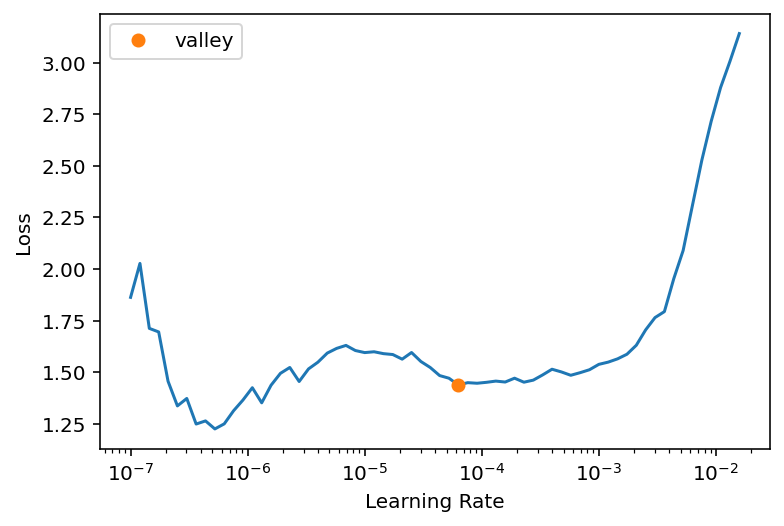

In [39]:
learn.lr_find()

In [40]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(2.0971, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([2, 70, 50264]))

In [41]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.504304,1.568655,0.338741,0.204829,0.292968,0.586882,0.630441,0.606475,2:31:41


Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

In [36]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"CHP’nin eski genel başkanı Deniz Baykal’ın avukatlarıyla birlikte basın toplantısı düzenleyen “Ulusal Kriminal Büro”nun açıklamaları medyada iki değişik şekilde algılandı. Köşe yazarlarının çoğunluğu, Baykal’ı istifaya sürükleyen görüntülerdeki kişilerin Deniz Baykal ve Nesrin Baytok olmadığına ilişkin açıklamaları “gereksiz, yersiz, geç” olarak değerlendirip inandırıcı bulmadı. Bazı köşe yazarları ise Baykal’a ve açıklamalara hak veren yazılar yazdı. İşte o yazılar… AÇIK",'Kasettekiler Baykal ve Baytok değildi' açıklamalarını medya inandırıcı buldu mu? İşte köşe yazarlarının değerlendirmeleri…,"[ Baykal'ın avukatlarıyla birlikte basın toplantısı düzenleyen açıklamaları medyada iki değişik şekilde algılandı., Google Türkiye dün gerçekleştirdiği bir toplantıyla, 6.000’den fazla KOBİ’ye veri analizlerinden ve internetin sağladığı diğer avantajlardan faydalanarak işlerini nasıl büyütebilecekleri konusunda eğitim vermek amacıya bir yıl sürecek bir proje başlattı.]"


## News Data Seft for "facebook/bart-large-cnn"

In [31]:
dls = dblock.dataloaders(results, bs=2)

In [32]:
results

,text,summary
0,"NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞDIRDI FUTBOL OYNARKEN EĞLENİYORUM YÜZDE 701E OYNUYORUM LİDERLE ARAMIZDA SADECE 5 PUAN VAR, ŞAMPİYONLUK ŞANSIMIZ YÜKSEK 4 j Fernandes le birlikte oynamayı seviyorum, adam adeta sihirbaz gibi J Frank Ribery, futbol hayatımda oynamaktan en çok zevk aldığım isim ı Abartılacak bir ] sonuç almadık ı .BAHÇE derbisinde Kartal ın ilk golünü atan, üçüncü golün de asistini yapan Mamadou Niang, TRT Spor da Futbol Keyfi programında özel açıklamalar yaptı. Senegalli forvet şampiyonluk şanslarının yüksek olduğunu dile getirirken, Portekizli yıldız Fernandes ...",BİR SİHİRBAZ
1,"E-ticarette farklılaşmanın . .. anahtarı: kullanıcı deneyimi Bir siteye girip iletişim bilgisi bölümünü bulamadığımızda değerini daha iyi anladığımız kullanıcı deneyimi tasarımı, bir yandan satın alma kararlarında çok etkili olurken diğer yandan uzun süreli kullanıcı memnuniyeti yaratmanın da anahtarıV 42 %44 %72 MAYIS 2014- DIGITALAGE.COM.TR M ? ijital ya da fiziksel bir ürün kullanırken hissettiklerimiz, ürünle kurduğumuz bağlantı ve yaşadığımız etkileşimin bütünü kullanıcı deneyimi olarak tanımlanabilir. Gittikçe dijitalleşen h...",E-TİCARETTE FARKLILAŞMANIN ANAHTARI
2,"212 de şenlik 212 istanbul Povver Outlet, 3 Aralık Dünya Özürlüler Günü nde farklı bir etkinliğe imza atıyor. AREM (Avrupa Rehabilitasyon Merkezi) işbirliğiyle gerçekleştirilen şenlikte engelli minikler kendi tasarladıkları topaçları çevirecek.",212'DE ŞENLİK
3,"Geleceğe yeşeren tohumlar Botanist ve tarihçiler, geri getirmesi belki daha kolay, risksiz ve dünyanın geleceği için de büyük ihtimal daha faydalı birşeyi geri getirmeye çalışıyorlar: Bitkileri... Kaybolmaya yüz tutmuş bitki örtülerini yeniden canlandırma çabası, insanlık için yapılabilecek en büyük iyiliklerden biri. PEYNİR GEMİSİ ELİF SAVAŞ FELSEN I info@elifsavas.com Eski DNA lardan kırpıp kırpıp yıldız yapmak mümkün mu7 Binlerce yıl önce dünyayı heybetlerıyle ele geçirmiş dınazorlar ve nesli tükenmiş daha nice yaratık belki birgün sıradan sayılacak bir teknolojinin gelmesini bekliyor o...",GELECEĞE YEŞEREN TOHUMLAR
4,"1 nceleme Exper iasyPad P10AN syPad Türkiye nin ilk tablet bilgisayarı şeklinde lanse edildi 10 Şubat ta. Biz internet tablet demeyi yeğliyoruz. Ekranı dönebilen ve katlanabilen dizüstü bilgisayarlara Tablet PC denmesini daha doğru buluyoruz. Exper Genel Müdürü Orhan Korkusuz; Android 2.2 işletim sistemli ve çift çekirdekli Nvidia Tegra 250 işlemcili (1 GHz) EasyPad P10AN ile VVindovvs 7 işlerim sistemli, Intel Atom N450 işlemcili (1.6 GHz) EasyPad Pil IMS ürün tanıtım lansmanmda, bu yıl dünyada ortalama 50 milyon civarında internet tablet satılmasının beklendiğini açıkladı. Türkiye ni...",EXPER
...,...,...
24995,"Genç Kramponlar fa çeyrek finale son bileti Atatürk Teknik ve Çağlayan kaptı. Kepez Anadolu İmam Hatip i 10-0 yenen Atatürk Teknik EML ise en farklı galibiyete imza attı BUGÜNÜN MAÇLARI jFiztööJ Turnuvası KEPEZ 4. Genç Kramponlar Futbol Turnuvası nda çeyrek finaldeki son 2 biletin de sahibi belli oldu. Dün oynanan 2 maçta rakiplerini yenen Atatürk Teknik Endüstri Meslek Lisesi ile Çağlayan Anadolu Lisesi, çeyrek finale isimlerini yazdırdı. Rakibi Kepez Anadolu İmam Hatip Lisesi ni 10-0 yenen Atatürk Teknik Endüstri Meslek Lisesi, turnuvanın en farklı skoruna imza attı. Çağlayan Anadolu Lis...",SON ÇEYREK FİNALİSTLER
24996,"Çocukları gitme dedi dinlemedi KONYA DA 78 yaşındaki Mustafa Altım, bahçesini sulamak için su kanalının kapağını açmak istediği sırada düşüp kafasını çarparak hayatını kaybetti. 3 teÇocukları gitme diye ısrar etmiş ama Konya da 78 yaşındaki Mustafa Altun, bahçesini sulamak için su kanalının kapağını açmak istediği sırada düşüp kafasını çarparak hayatını kaybetti Olay, saat 08.00 sıralarında merkez Meram ilçesi Dere Aşıklar Mahallesi nde meydana geldi. İddiaya göre, çocuklarının gitme ısrarlarına rağmen sabah erken saatlerde bahçesini sulamak su kanalına gelen Mustafa Altun (78), kanal...",ÇOCUKLARI GİTME DEDİ DİNLEMEDİ
24997,"BAYINDIR

In [33]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'tr' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [34]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

SuggestedLRs(valley=7.585775892948732e-05)

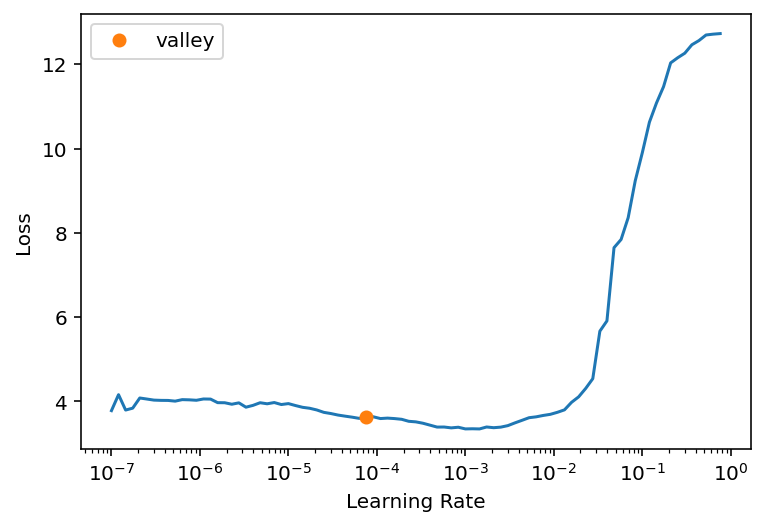

In [35]:
learn.lr_find()

In [36]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(4.0211, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([2, 54, 50264]))

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

In [ ]:
learn.show_results(learner=learn, max_n=2)